In [1]:
# standard dependencies
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import sys
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# local package dependencies
sys.path.append(os.path.abspath("../../scripts/"))
sys.path.append(os.path.abspath("../../visualizations/"))

# for making direct query requests to the data warehouse
from oso_db import execute_query

# for making visualizations
from contribution_heatmap import contribution_heatmap
from venn_diagram import venn3_diagram

In [6]:
# create a mapping of projects to collections
result = execute_query("""
    SELECT p."slug", c."slug" 
    FROM project p 
    JOIN collection_projects_project cpp ON p."id" = cpp."projectId"
    JOIN collection c ON cpp."collectionId" = c."id"
    WHERE c."typeId" = 1
""", col_names=False)
projects_to_collections = {
    k: (
        sorted([
            v for v, key
            in result
            if key == k
        ]) 
    )
    for k in set(key for _, key in result)
}

In [16]:
# create a list of collections (ecosystems)
collection_slugs = list(projects_to_collections.keys())
collection_slugs[-5:]

['op-onchain',
 'op-govgrants-rfg6',
 'op-govgrants-incentive-program-launched',
 'op-govgrants-cycle-7-(phase-1)',
 'op-govgrants-grants-season-2']

In [20]:
# create a list of projects
project_slugs = set([
    p for c,ps 
    in projects_to_collections.items() 
    if c in collection_slugs 
    for p in ps
])
len(project_slugs)

1044

(<Figure size 1440x1440 with 1 Axes>, <Axes: >)

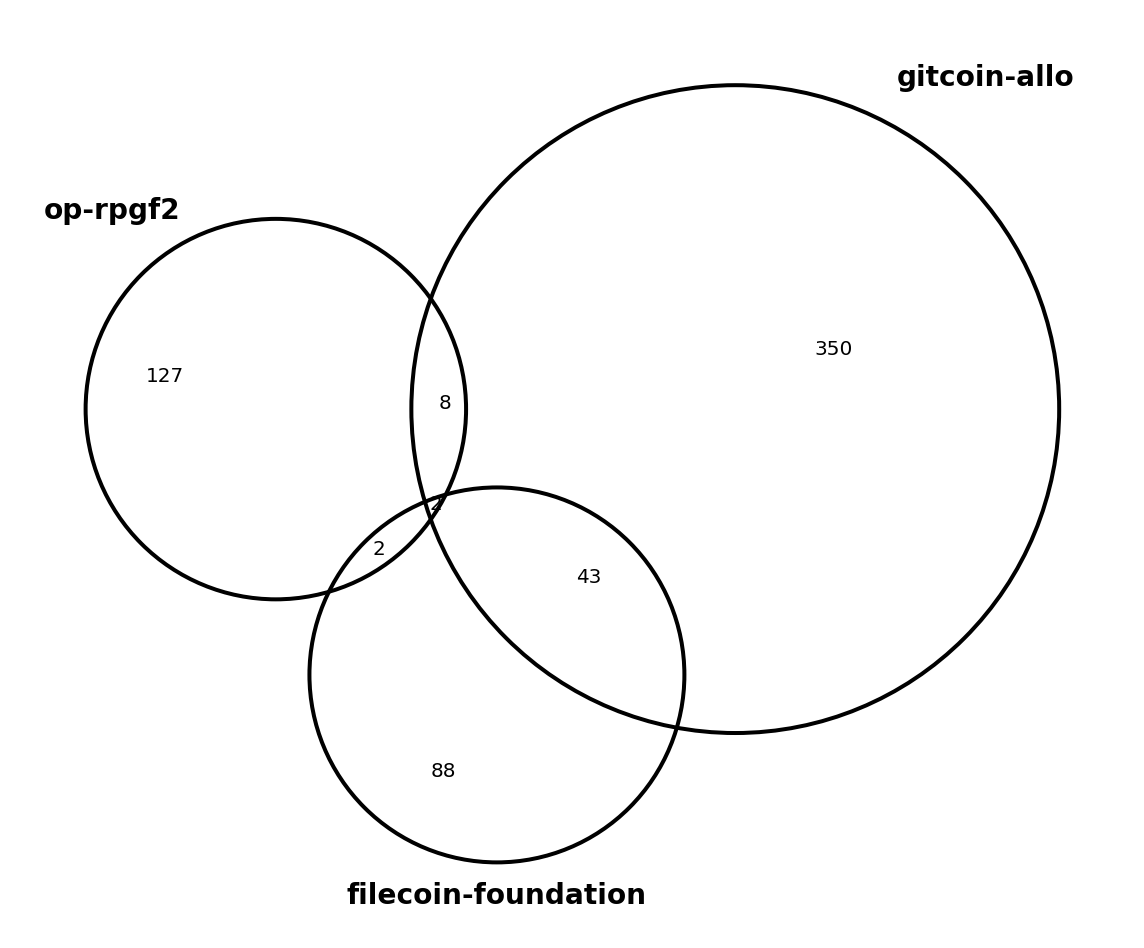

In [22]:
selected_collections = ["op-rpgf2", "gitcoin-allo", "filecoin-foundation"]
venn3_diagram(
    [set(ps) for c,ps in projects_to_collections.items() if c in selected_collections], 
    selected_collections,
    labelcolor="black",
    fontsize=12
)

In [23]:
# filter on the project slugs we're interested in
my_slugs = projects_to_collections['gitcoin-allo']
len(my_slugs)

403

In [25]:
# create a string version of the projects list for use in querystrings
slugs_str = "','".join(my_slugs)

In [26]:
# get the names of those projects (up to 24 characters)
result = execute_query(f"""
    SELECT slug, name
    FROM project 
    WHERE slug IN ('{slugs_str}') 
""")
slugs_to_names = {x[0]: x[1][:24] for x in result}

In [30]:
# get data about active developers
devs_query = execute_query(f"""
    WITH Devs AS (
        SELECT 
            p."slug" AS "slug",
            e."fromId" AS "fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
            CASE WHEN COUNT(DISTINCT e."time") >= 10 THEN 1 ELSE 0 END AS "full_time_developer",
            CASE WHEN COUNT(DISTINCT e."time") < 10 THEN 1 ELSE 0 END AS "part_time_developer"
        FROM event e             
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId" = 4 -- COMMIT CODE EVENTS ONLY
            AND p.slug IN ('{slugs_str}')
        GROUP BY
            p."slug",
            e."fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
    )
    SELECT 
        slug,
        month,
        SUM("full_time_developer") AS "Full time developers",
        SUM("part_time_developer") AS "Part time developers"
    FROM Devs
    WHERE month >= '2014-01'
    GROUP BY slug, month
    ORDER BY slug, month;
""", col_names=True)

df_devs = pd.DataFrame(devs_query[1:], columns=devs_query[0])
df_devs['sum'] = df_devs['Full time developers'] + df_devs['Part time developers']
df_devs['project'] = df_devs['slug'].map(slugs_to_names)
df_devs.head()

slug    month  Full time developers  Part time developers  \
0              0u0-ai  2023-02                     1                     0   
1              0u0-ai  2023-03                     1                     1   
2              0u0-ai  2023-04                     0                     1   
3              0u0-ai  2023-05                     1                     0   
4  0x-boring-security  2022-03                     0                     1   

   sum  
0    1  
1    2  
2    1  
3    1  
4    1

Text(0.0, 1.0, 'Monthly active developers')

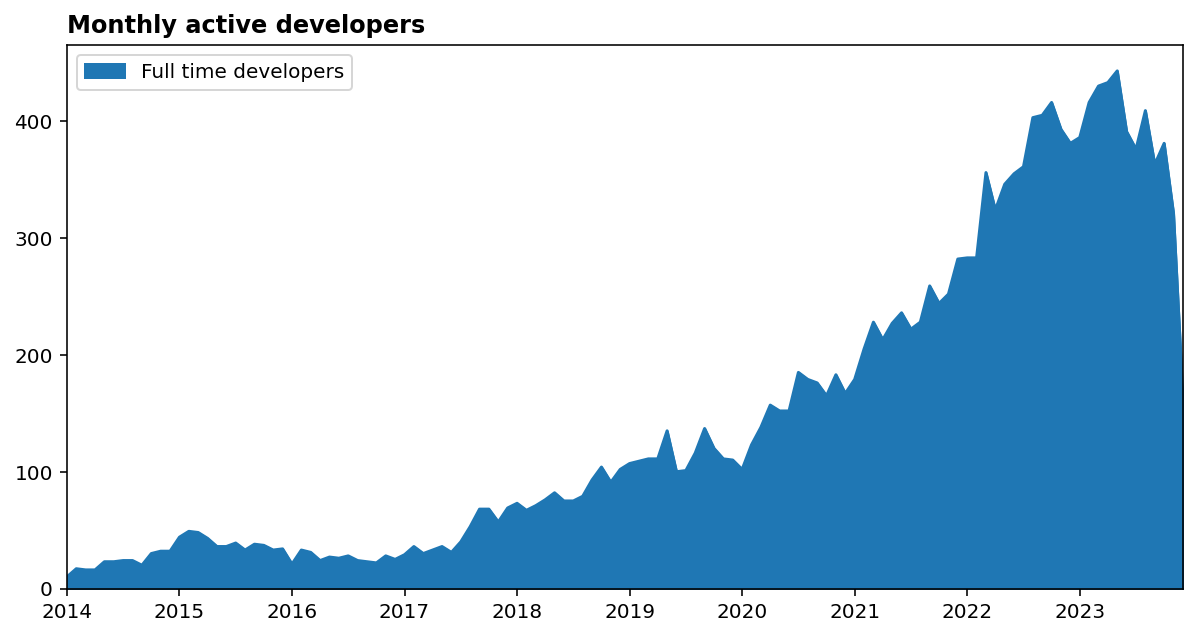

In [31]:
# visualize developer activity (all projects:contributor pairings) over time
fig, ax = plt.subplots(figsize=(10,5), facecolor='white', dpi=144)
(
    df_devs
    .groupby('month')
    [['Full time developers']]
    .sum()
    .plot(
        kind='area', 
        ax=ax
    )
)

months = df_devs['month'].nunique()
ax.set_xlim([0,months-1])
ax.set_xticks([x for x in range(0,months,12)])
xticklabels = [x[:-3] for x in sorted(df_devs['month'].unique())[::12]]
ax.set_xticklabels(xticklabels)
ax.set_xlabel("")
ax.set_ylabel("")

ax.set_title('Monthly active developers', fontweight="bold", loc='left')

In [38]:
# make a heatmap
fig, ax = contribution_heatmap(
    df_devs,
    index_col='project',
    column_col='month',
    value_col='Full time developers',
    sort_label_method='mean',
    dpi=300,
    cmap='Greens',
    vmax=10,
    #figsize=(15,9)
)

ax.set_title("Full time developers by project", fontweight="bold", loc='left', fontsize=24)

Text(0.0, 1.0, 'Full time developers by project')